In [42]:
import logging
logger = logging.getLogger()
logger.setLevel(logging.INFO)

import sys
sys.path.append("../../../")

import numpy as np

%matplotlib widget

In [43]:
from qiskit import transpile
from qiskit import QuantumCircuit
from qiskit.circuit.random import random_circuit
from weyl_decompose import RootiSwapWeylDecomposition as decomposer
from qiskit.transpiler.passes import Collect2qBlocks, ConsolidateBlocks, Unroll3qOrMore, Optimize1qGates
from src.utils.custom_gates import RiSwapGate
from qiskit.circuit.library import CXGate
from qiskit.converters import circuit_to_dag
from qiskit.transpiler.basepasses import TransformationPass
from qiskit.quantum_info import Operator
from src.basis import MixedOrderBasisCircuitTemplate
from src.utils.polytope_wrap import monodromy_range_from_target
from src.scripts.gate_exploration.bgatev2script import get_group_name, cost_scaling, pick_winner
from qiskit.transpiler.basepasses import AnalysisPass
from qiskit.transpiler.passes import CountOps
from qiskit.dagcircuit import DAGOpNode, DAGCircuit
from qiskit.transpiler import PassManager
from itertools import product

In [44]:
from qiskit.circuit.library import QuantumVolume, QFT
qc = QuantumVolume(8, depth=8).decompose()
#qc = QFT(3).decompose()
duration_1q = .5

In [45]:
# load square-lattice coupling map or all-to-all
from qiskit.transpiler import CouplingMap
coupling_map = CouplingMap.from_grid(4, 4)
#coupling_map = CouplingMap.from_full(16)

# load qiskit transpiler with pass for coupling map
induce_swaps = lambda qc: transpile(qc, coupling_map=coupling_map, optimization_level=3)

# turn off logging
logger.setLevel(logging.ERROR)
qc = induce_swaps(qc)
# turn back on logging
logger.setLevel(logging.INFO)

In [46]:
from src.scripts.transpiler_pass.speed_limit_pass import pass_manager_basic, pass_manager_slam

INFO:qiskit.transpiler.runningpassmanager:Pass: Unroll3qOrMore - 0.05937 (ms)
INFO:qiskit.transpiler.runningpassmanager:Pass: Collect2qBlocks - 0.41103 (ms)
INFO:qiskit.transpiler.runningpassmanager:Pass: ConsolidateBlocks - 33.20956 (ms)
INFO:root:winner: 2QGate(0.00000000, 0.78539816, 1.00000000), scores: [2.70988264 2.5        3.5       ], cost: 0.5
INFO:root:scaled scores: [ 1.35494132  1.25        1.75       -0.25       -0.25      ], scaled cost: 0.5
INFO:root:Found winner, begin substitution
INFO:qiskit.transpiler.runningpassmanager:Pass: SpeedGateSubstitute - 245.50748 (ms)
INFO:qiskit.transpiler.runningpassmanager:Pass: Optimize1qGates - 36.94987 (ms)
INFO:qiskit.transpiler.runningpassmanager:Pass: CountOps - 0.01526 (ms)
INFO:root:
Transpilation Results:
INFO:root:Gate Counts: {'2QGate(0.00000000, 0.78539816, 1.00000000)': 41, 'u3': 90}
INFO:root:Longest Path Gate Counts: {'u3': 25, '2QGate(0.00000000, 0.78539816, 1.00000000)': 24}
INFO:root:Duration: 24.5
INFO:qiskit.transpil

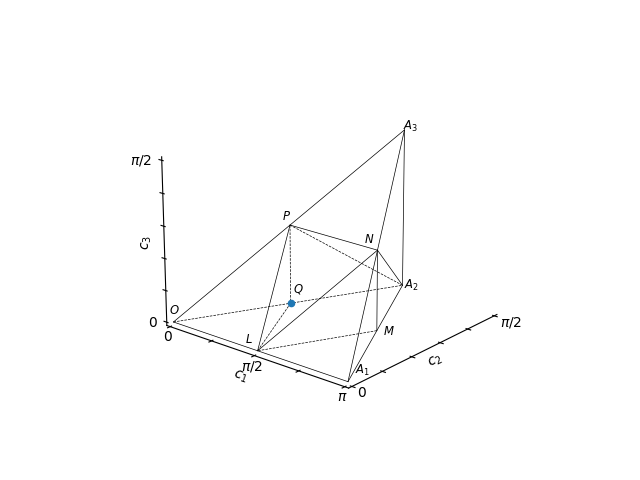

In [47]:
method = ['linear', 'mid', 'squared', 'hardware'][0]
strategy = ['basic_overall', 'weighted_overall', 'weighted_pairwise'][0]
basic_metric = [0,1,2][2]
pm = pass_manager_slam(strategy=strategy, speed_method=method, duration_1q=duration_1q, basic_metric=basic_metric)
transp0 = pm.run(qc)

INFO:qiskit.transpiler.runningpassmanager:Pass: Unroll3qOrMore - 0.03123 (ms)
INFO:qiskit.transpiler.runningpassmanager:Pass: Collect2qBlocks - 0.21195 (ms)
INFO:qiskit.transpiler.runningpassmanager:Pass: ConsolidateBlocks - 30.34830 (ms)
100%|██████████| 176/176 [00:02<00:00, 59.94it/s]
INFO:root:winner score: 121.5, normalized score: 2.9634146341463414
INFO:root:winner: 2QGate(0.00000000, 0.78539816, 1.00000000), scores: [2.70988264 2.5        3.5       ], cost: 0.5
INFO:root:scaled scores: 2.5, scaled cost: 0.5
INFO:root:Found winner, begin substitution
INFO:qiskit.transpiler.runningpassmanager:Pass: SpeedGateSubstitute - 3121.40059 (ms)
INFO:qiskit.transpiler.runningpassmanager:Pass: Optimize1qGates - 36.86976 (ms)
INFO:qiskit.transpiler.runningpassmanager:Pass: CountOps - 0.01335 (ms)
INFO:root:
Transpilation Results:
INFO:root:Gate Counts: {'2QGate(0.00000000, 0.78539816, 1.00000000)': 41, 'u3': 90}
INFO:root:Longest Path Gate Counts: {'u3': 25, '2QGate(0.00000000, 0.78539816, 1.

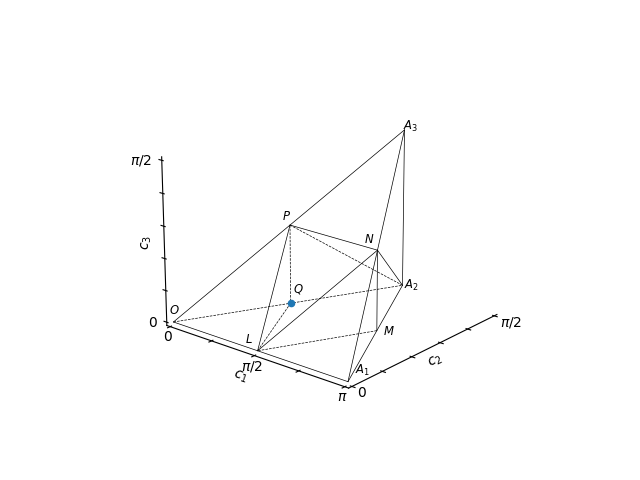

In [48]:
method = ['linear', 'mid', 'squared', 'hardware'][0]
strategy = ['basic_overall', 'weighted_overall', 'weighted_pairwise'][1]
pm = pass_manager_slam(strategy=strategy, speed_method=method, duration_1q=duration_1q)
transp0 = pm.run(qc)

INFO:qiskit.transpiler.runningpassmanager:Pass: Unroll3qOrMore - 0.03290 (ms)
INFO:qiskit.transpiler.runningpassmanager:Pass: Collect2qBlocks - 0.21577 (ms)
INFO:qiskit.transpiler.runningpassmanager:Pass: ConsolidateBlocks - 28.15104 (ms)
INFO:root:Iterating over edges, finding winners
100%|██████████| 24/24 [00:08<00:00,  2.83it/s]
INFO:qiskit.transpiler.runningpassmanager:Pass: SpeedGateSubstitute - 8482.93138 (ms)
INFO:qiskit.transpiler.runningpassmanager:Pass: Optimize1qGates - 35.77113 (ms)
INFO:qiskit.transpiler.runningpassmanager:Pass: CountOps - 0.01216 (ms)
INFO:root:
Transpilation Results:
INFO:root:Gate Counts: {'2QGate(0.00000000, 0.78539816, 1.00000000)': 21, '2QGate(0.10799225, 0.97193023, 1.00000000)': 3, '2QGate(0.03926991, 0.74612826, 1.00000000)': 6, '2QGate(0.08835729, 0.79521564, 1.00000000)': 6, '2QGate(0.04908739, 0.93266032, 1.00000000)': 3, '2QGate(0.00000000, 0.68722339, 1.00000000)': 2, 'u3': 90}
INFO:root:Longest Path Gate Counts: {'u3': 25, '2QGate(0.0000000

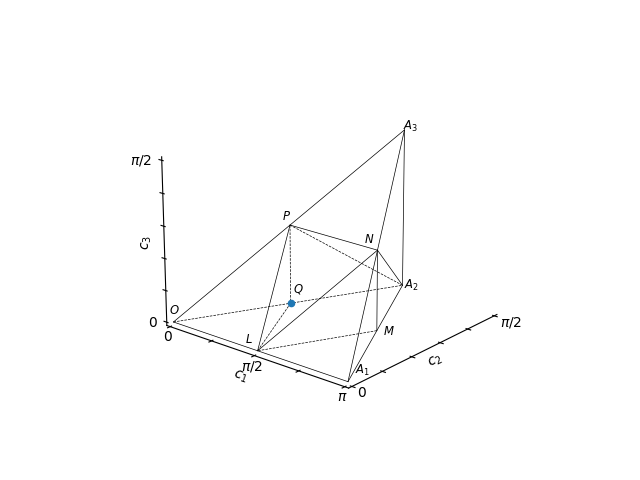

In [49]:
method = ['linear', 'mid', 'squared', 'hardware'][0]
strategy = ['basic_overall', 'weighted_overall', 'weighted_pairwise'][2]
pm = pass_manager_slam(strategy=strategy, speed_method=method, duration_1q=duration_1q, coupling_map=coupling_map)
transp0 = pm.run(qc)

In [54]:
#transp1 = transpile(qc, optimization_level=3, basis_gates=['u', 'id', 'cx'])
pm = pass_manager_basic(gate='iswap', duration_1q=duration_1q)
transp1 = pm.run(qc)

INFO:qiskit.transpiler.runningpassmanager:Pass: Unroll3qOrMore - 0.03099 (ms)
INFO:qiskit.transpiler.runningpassmanager:Pass: Collect2qBlocks - 0.21696 (ms)
INFO:qiskit.transpiler.runningpassmanager:Pass: ConsolidateBlocks - 27.96412 (ms)
INFO:qiskit.transpiler.runningpassmanager:Pass: RootiSwapWeylDecomposition - 212.21447 (ms)
INFO:qiskit.transpiler.runningpassmanager:Pass: Optimize1qGates - 62.54911 (ms)
INFO:qiskit.transpiler.runningpassmanager:Pass: CountOps - 0.02480 (ms)
INFO:root:
Transpilation Results:
INFO:root:Gate Counts: {'u3': 210, 'riswap': 101}
INFO:root:Longest Path Gate Counts: {'u3': 63, 'riswap': 62}
INFO:root:Duration: 62.5
INFO:qiskit.transpiler.runningpassmanager:Pass: fooAnalysis - 3.84116 (ms)


In [55]:
#transp1 = transpile(qc, optimization_level=3, basis_gates=['u', 'id', 'cx'])
pm = pass_manager_basic(gate='cx')
transp1 = pm.run(qc)

INFO:qiskit.transpiler.runningpassmanager:Pass: Unroll3qOrMore - 0.03195 (ms)
INFO:qiskit.transpiler.runningpassmanager:Pass: Collect2qBlocks - 0.22531 (ms)
INFO:qiskit.transpiler.runningpassmanager:Pass: ConsolidateBlocks - 29.27685 (ms)
INFO:qiskit.transpiler.runningpassmanager:Pass: RootiSwapWeylDecomposition - 118.39151 (ms)
INFO:qiskit.transpiler.runningpassmanager:Pass: Optimize1qGates - 73.82989 (ms)
INFO:qiskit.transpiler.runningpassmanager:Pass: CountOps - 0.02527 (ms)
INFO:root:
Transpilation Results:
INFO:root:Gate Counts: {'u3': 227, 'cx': 123, 'u2': 26}
INFO:root:Longest Path Gate Counts: {'u3': 53, 'cx': 72, 'u2': 20}
INFO:root:Duration: 72
INFO:qiskit.transpiler.runningpassmanager:Pass: fooAnalysis - 5.32055 (ms)


In [52]:
# noisy simulation to calculate QV
# use a QV that includes random gates all over weyl chamber

In [53]:
# can we come up with an analytical/proof relating gates to work for cnot